# Credmark Workshop for MetricsDAO

- 2023.6.20
- Join Credmark Discord: https://credmark.com/contact-us

1. Token (symbol, name, )
2. Contract (Uniswap V2)
3. Get the reserve, get the price
4. Get the reserve for the past
5. Get the reserve for a range of time.


## Initialize


In [1]:
from credmark.cmf.ipython import create_cmf
from credmark.cmf.types import Token, Contract, Address, BlockNumber

context, model_loader = create_cmf(show=True)

Credmark context created with 
- chain_id=1
- block_number=None
- chain_provider_url=http://192...8545
- model_loader_path=['/home/yangye/dev/credmark/credmark-models-py/models']
- api_url=https://gateway.credmark.com
- use_local_models=None



In [2]:
# print the chain ID, block number and block timestamp
print((context.chain_id, context.block_number, context.block_number.timestamp_datetime.isoformat()))

(1, 17478613, '2023-06-14T13:56:11+00:00')


## 1. Token


In [3]:
# WBTC token
wbtc = Token('0x2260fac5e5542a773aa44fbcfedf7c193bc2c599')
print((wbtc.symbol, wbtc.total_supply, wbtc.decimals))

# These values shall match closely with what's shown in
# https://etherscan.io/address/0x2260fac5e5542a773aa44fbcfedf7c193bc2c599#readContract
# We have shown as live, while EtherScan update some time ago.

('WBTC', 15674767544250, 8)


## 2. Contract

- We choose an exchange pool from Uniswap V2
- https://v2.info.uniswap.org/home
- V2 pool is simple because the ratio between two tokens' reserves is the price.

For example:

- The USDC-ETH pool is composed of two tokens: USDC and ETH.
- The pool's reserves are the total amount of USDC and ETH in the pool.
- ETH's price in USDC is USDC's reserve divided by ETH's reserve.


In [4]:
eth_usdc_pool = Contract('0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc')

# Explore the pool contract
display(dir(eth_usdc_pool.abi.functions))

# The detail of token0/token1/getReserves function
print(eth_usdc_pool.abi.functions.token0)
print('---')
print(eth_usdc_pool.abi.functions.token1)
print('---')
print(eth_usdc_pool.abi.functions.getReserves)

['DOMAIN_SEPARATOR',
 'MINIMUM_LIQUIDITY',
 'PERMIT_TYPEHASH',
 'allowance',
 'approve',
 'balanceOf',
 'burn',
 'decimals',
 'factory',
 'getReserves',
 'initialize',
 'kLast',
 'mint',
 'name',
 'nonces',
 'permit',
 'price0CumulativeLast',
 'price1CumulativeLast',
 'skim',
 'swap',
 'symbol',
 'sync',
 'token0',
 'token1',
 'totalSupply',
 'transfer',
 'transferFrom']

Function Name: token0
Args: []
Types: []
Output: ['address']
---
Function Name: token1
Args: []
Types: []
Output: ['address']
---
Function Name: getReserves
Args: []
Types: []
Output: ['uint112', 'uint112', 'uint32']


In [5]:
token0_addr = eth_usdc_pool.functions.token0().call()
token1_addr = eth_usdc_pool.functions.token1().call()

# The addresses of two tokens
print((token0_addr, token1_addr))

# Know what these tokens are actually are
token0 = Token(token0_addr)
token1 = Token(token1_addr)
print((token0.symbol, token1.symbol))

('0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')
('USDC', 'WETH')


In [6]:
# Get the reserve of two tokens in this pool
reserve = eth_usdc_pool.functions.getReserves().call()
print((reserve))

# split the return tuple to three values
_reserve0, _reserve1, _block_timestamp_last = reserve

# price of ETH (as token1) = reserve0 / reserve1, scaled by each token's decimals
price_eth = token0.scaled(_reserve0) / token1.scaled(_reserve1)

print(price_eth)

[26738130676431, 15338960478961100637376, 1686750923]
1743.1514158410532


## 3. Write a model


In [7]:
from credmark.cmf.model import Model


@Model.describe(
    slug='jit.uniswap-v2-reserve',
    version='1.1',
    input=Contract,
    output=dict)
class UniswapV2Reserve(Model):
    def run(self, input):
        token0_addr = input.functions.token0().call()
        token1_addr = input.functions.token1().call()
        token0 = Token(token0_addr)
        token1 = Token(token1_addr)
        _reserve0, _reserve1, _block_timestamp_last = input.functions.getReserves().call()
        price_token1 = token0.scaled(_reserve0) / token1.scaled(_reserve1)
        return {'price_token1': price_token1,
                'price_token0': 1 / price_token1,
                'reserve0': _reserve0,
                'reserve1': _reserve1}


# We can save this as a file in the models/ directory of credmark-models-py to load it
# Here we directly load it from the definition, with this way, it can only be used in this notebook.
context.add_model(UniswapV2Reserve)

In [8]:
context.run_model('jit.uniswap-v2-reserve',
                  {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'})

{'price_token1': 1743.1514158410532,
 'price_token0': 0.0005736736297905079,
 'reserve0': 26738130676431,
 'reserve1': 15338960478961100637376}

In [9]:
# We can run model on earlier block

earlier_block = context.block_number - 1_000

display(earlier_block.timestamp_datetime)

context.run_model('jit.uniswap-v2-reserve',
                  {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'},
                  block_number=earlier_block)

datetime.datetime(2023, 6, 14, 10, 32, 59, tzinfo=datetime.timezone.utc)

{'price_token1': 1743.3280786584983,
 'price_token0': 0.000573615495695742,
 'reserve0': 26833265247563,
 'reserve1': 15391976746116177766125}

## 4. Scale up the model for more blocks


In [23]:
# Run the model for 1000 blocks will take a while, how could we speed up?

for offset in range(10):
    context.run_model('jit.uniswap-v2-reserve',
                      {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'},
                      block_number=context.block_number - offset)

In [48]:
# Uniswap V2 pool's reserve changes with Mint/Burn/Swap, it kept a record of these events.
# Event Sync occurs together with Mint/Burn to record the reserve, that's we need.
# Let's query the ledger database for the event log for Sync.
# Querying this data only takes less than a second.

with eth_usdc_pool.ledger.events.Sync as q:
    df = q.select(q.columns,
                  where=q.BLOCK_NUMBER.ge(context.block_number-1000),
                  order_by=q.BLOCK_NUMBER.comma_(q.LOG_INDEX)).to_dataframe()

# Note: Because we limit each query to return 5000 results
# We may query multiple times to get all the results till we have exhausted all the results.

display(df)

,block_number,block_timestamp,contract_address,log_index,signature,transaction_hash,evt_reserve0,evt_reserve1
0,17477617,2023-06-14T10:33:47.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,71,"Sync(uint112,uint112)",0x37ab7b663e4945d8e2f473a25f421231612df3374429...,26833215543395,15392005343041231768921
1,17477634,2023-06-14T10:37:11.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,156,"Sync(uint112,uint112)",0x3ced4f75a7909afe6cad137c97a362df906af75ff087...,26833215543388,15392005343045357220460
2,17477640,2023-06-14T10:38:23.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,131,"Sync(uint112,uint112)",0xd548e01c22814093719c98a96a89e2cc06aec43efac1...,26833375543388,15391913840105957222992
3,17477642,2023-06-14T10:38:47.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,993,"Sync(uint112,uint112)",0x28d9a8f4153fec49fd4d20f2a25e06991cf64ebb318c...,26833366067421,15391919291980957222992
4,17477644,2023-06-14T10:39:11.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,243,"Sync(uint112,uint112)",0x744effb672e66099a5c70b5fc090ccf522fcaefdaa10...,26833599558887,15391785761619504612136
...,...,...,...,...,...,...,...,...
113,17478490,2023-06-14T13:31:11.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,179,"Sync(uint112,uint112)",0xed7d86473154e7a1d4f75190bdfc971ee2c9f9f22610...,26850150411945,15381790908202654417986
114,17478494,2023-06-14T13:31:59.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,141,"Sync(uint112,uint112)",0x245f10603219907ffec68769116022b85e2729e160f8...,26849808817483,15381987190606868248332
115,17478502,2023-06-14T13:33:35.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,28,"Sync(uint112,uint112)",0xd77a8c41a6c52311cec01fdf140098e782ef0c15ab00...,26842135373053,15386397718541815434987
116,17478511,2023-06-14T13:35:23.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,193,"Sync(uint112,uint112)",0x94656c8de37d14b70569a4c05844c6da84371d30203a...,26748727521990,15332854648047482168584


In [49]:
# Our ETL process could lag from the current block number, we will fetch events after the last block number from data.
import pandas as pd

df_post_events = (pd.DataFrame(eth_usdc_pool.fetch_events(
    eth_usdc_pool.events.Sync,
    from_block=(
        (int(df.loc[df.shape[0]-1, 'block_number']) + 1)
        if not df.empty
        else context.block_number-input.block_range),
    to_block=context.block_number))
    .loc[:, ['blockNumber', 'reserve0', 'reserve1']]
    .rename(columns={'blockNumber': 'block_number'}))

display(df_post_events)

,block_number,reserve0,reserve1
0,17478539,26748353256488,15333069832361198314787
1,17478543,26747851880127,15333358108635182096331
2,17478545,26748351880127,15333072346002775665800
3,17478551,26750620055749,15331776160144260252717
4,17478553,26750655332028,15331756002676535031676
5,17478555,26748976042491,15332721420163533959255
6,17478588,26747314127301,15333676968731542699294
7,17478589,26747654383138,15333482494812595944801
8,17478596,26746297386239,15334262793415994545817
9,17478599,26742611987655,15336382366447125840226


,block_number,reserve0,reserve1
0,17477617,26833215543395,15392005343041231768921
1,17477634,26833215543388,15392005343045357220460
2,17477640,26833375543388,15391913840105957222992
3,17477642,26833366067421,15391919291980957222992
4,17477644,26833599558887,15391785761619504612136
...,...,...,...
113,17478490,26850150411945,15381790908202654417986
114,17478494,26849808817483,15381987190606868248332
115,17478502,26842135373053,15386397718541815434987
116,17478511,26748727521990,15332854648047482168584


,block_number,reserve0,reserve1,price_token1,price_token0
0,17477613,2.683322e+13,15392005343041231768921,1743.321610,0.000574
1,17477614,2.683322e+13,15392005343041231768921,1743.321610,0.000574
2,17477615,2.683322e+13,15392005343041231768921,1743.321610,0.000574
3,17477616,2.683322e+13,15392005343041231768921,1743.321610,0.000574
4,17477617,2.683322e+13,15392005343041231768921,1743.321610,0.000574
...,...,...,...,...,...
996,17478609,2.673813e+13,15338960478961100637376,1743.151416,0.000574
997,17478610,2.673813e+13,15338960478961100637376,1743.151416,0.000574
998,17478611,2.673813e+13,15338960478961100637376,1743.151416,0.000574
999,17478612,2.673813e+13,15338960478961100637376,1743.151416,0.000574


<Axes: xlabel='block_number'>

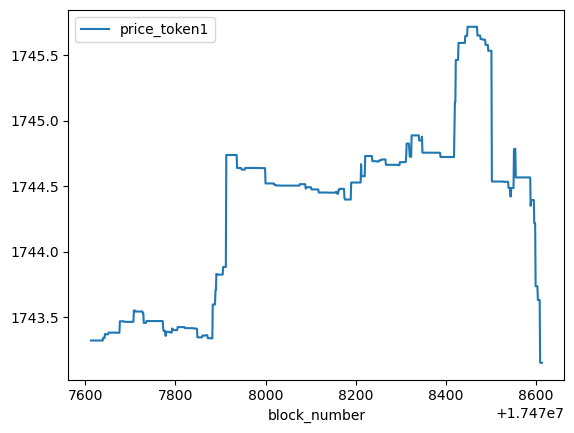

In [41]:
import pandas as pd

df_clean = (df
            .drop_duplicates(subset=['block_number'], keep='last')
            .loc[:, ['block_number', 'evt_reserve0', 'evt_reserve1']]
            .rename(columns={'evt_reserve0': 'reserve0', 'evt_reserve1': 'reserve1'})
            .assign(block_number=lambda x: x.block_number.astype(int),
                    reserve0=lambda x: x.reserve0.apply(int),
                    reserve1=lambda x: x.reserve1.apply(int),))

display(df_clean)

df_clean = pd.concat([df_clean, df_post_events]).reset_index(drop=True)

current_reserve = context.run_model('jit.uniswap-v2-reserve',
                                    {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'})

if df_clean.empty or df_clean.loc[df_clean.shape[0]-1, 'block_number'] != context.block_number:
    df_clean = pd.concat([
        df_clean,
        pd.DataFrame({'block_number': [context.block_number],
                      'reserve0': [current_reserve['reserve0']],
                      'reserve1': [current_reserve['reserve1']]})]).reset_index(drop=True)

df_clean['price_token1'] = token0.scaled(df_clean['reserve0']) / token1.scaled(df_clean['reserve1'])
df_clean['price_token0'] = 1 / df_clean['price_token1']

df_clean = (df_clean
            .merge(pd.DataFrame({'block_number': range(context.block_number-1000, context.block_number+1)}), how='right')
            .sort_values('block_number')
            .fillna(method='ffill')
            .fillna(method='bfill'))

display(df_clean)

df_clean.plot('block_number', 'price_token1')